In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing, post_process, contour_animated
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML

from apdist.utils import plot_warping 
from apdist.geometry import SquareRootSlopeFramework as SRSF
from apdist.torch import AmplitudePhaseDistance as torch_apdist
from apdist.torch import plot_warping as plot_warping_torch

from apdist.distances import AmplitudePhaseDistance as dist
import torch 

In [2]:
# q range to consider up to and including spline fit step
q_min_subtract = 0.002
q_max_subtract = 0.035

# q range to interpolate spline fit on and perform distance metric calculation with
q_min_spl = 0.003
q_max_spl = 0.03
n_interpolate_gridpts = 1001 # number of grid points to interpolate q on.

In [3]:
target_r_nm = 40 # particle size target
target_r_angs = target_r_nm*10
target_pdi = 0.1
sld_silica = 8.575
sld_etoh = 9.611

In [4]:
q_grid = np.linspace(np.log10(q_min_spl), np.log10(q_max_spl), n_interpolate_gridpts)

q_grid_nonlog = 10**q_grid
target_I = target_comparison.target_intensities(q_grid_nonlog, target_r_angs, target_pdi, sld_silica, sld_etoh)
target_I = np.log10(target_I)

In [5]:
q_grid_scaled = (q_grid - min(q_grid))/(max(q_grid) - min(q_grid))
N_SAMPLES = q_grid_scaled.shape[0]

In [6]:
optim_kwargs = {"n_iters":100, 
                "n_basis":15, 
                "n_layers":15,
                "domain_type":"linear",
                "basis_type":"palais",
                "n_restarts":5,
                "lr":1e-1,
                "n_domain":N_SAMPLES
                }

## Trajectory for baseline:

In [7]:
with open('baseline_replicate_0.pkl', 'rb') as f:
    baseline_1 = pickle.load(f)

In [8]:
best_samples = []
best_uuids = []
best_apdist = None
for uuid_val, entry in baseline_1.items():
    if best_apdist is None:
        best_apdist = entry['ap_distance_reporting']
        best_samples.append(entry)
        best_uuids.append(uuid_val)
    else:
        if entry['ap_distance_reporting'] < best_apdist:
            best_apdist = entry['ap_distance_reporting']
            best_samples.append(entry)
            best_uuids.append(uuid_val)

In [9]:
torch.from_numpy(entry['I_scaled'])

tensor([4.7805, 4.7754, 4.7704,  ..., 0.7879, 0.7840, 0.7801],
       dtype=torch.float64)

67260a72-43e1-4bec-aaa7-6500d4106411
tensor(0.9078)
tensor(0.9278, dtype=torch.float64)


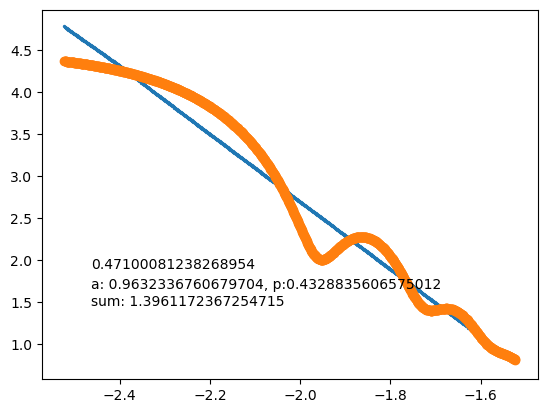

de7e6170-d1fd-49ca-970b-f01b77c1e9fc
tensor(0.9517)
tensor(0.2857, dtype=torch.float64)


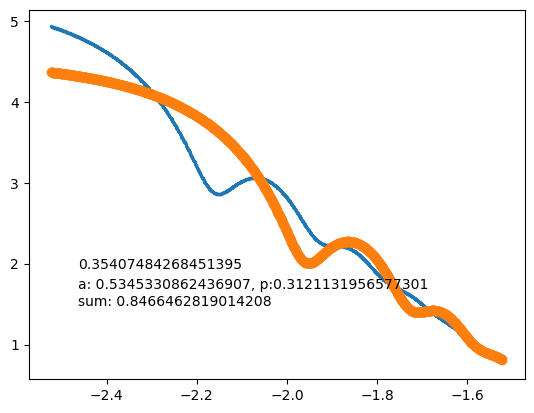

7b544b65-7596-4ff0-b700-507fd9e9f087
tensor(0.9549)
tensor(0.1467, dtype=torch.float64)


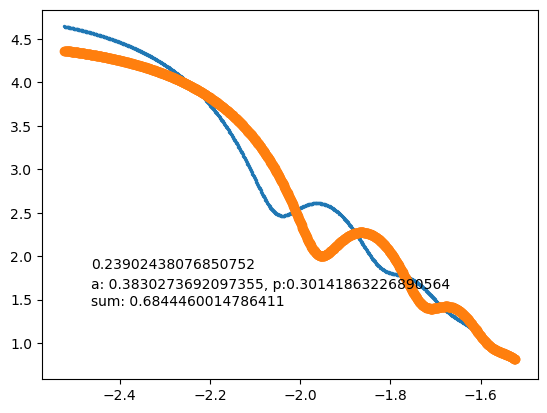

b3bf5475-b9df-4c5f-ac49-3562e87c7ead
tensor(nan)
> /home/ubuntu/miniconda3/envs/botorch/lib/python3.12/site-packages/apdist/torch.py(67)_phase_distance()
     65         if torch.isnan(theta):
     66             pdb.set_trace()
---> 67         dist = torch.arccos(torch.clamp(theta, -1, 1))
     68 
     69     return dist



In [ ]:
for uid, entry in zip(best_uuids, best_samples):
    print(uid)
    amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(entry['I_scaled']), 
                                        **optim_kwargs
                                        )
    fig, ax = plt.subplots()
    ax.scatter(q_grid, entry['I_scaled'], s = 2)
    ax.scatter(q_grid, target_I)
    ax.text(0.1, 0.3, entry['ap_distance_reporting'],  transform=ax.transAxes)
    ax.text(0.1, 0.2, f'a: {amplitude}, p:{phase}\nsum: {amplitude + phase}',  transform=ax.transAxes)
    plt.show()


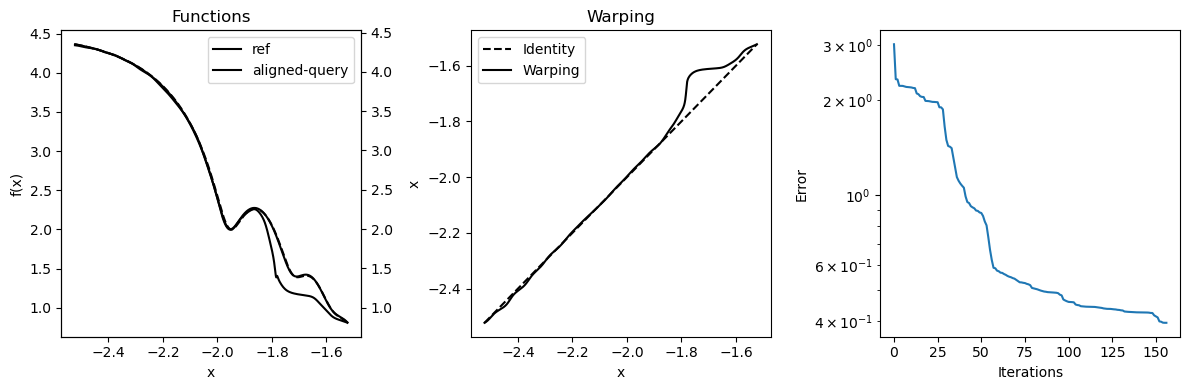

In [66]:
plot_warping_torch(q_grid, target_I, entry['I_scaled'], output)

In [78]:
I_baseline_bad = best_samples[0]['I_scaled']
amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(I_baseline_bad), 
                                        **optim_kwargs
                                        )

tensor(0.8708)
tensor(0.4349, dtype=torch.float64)


Amplitude: 0.659439455328535
Phase: 0.513950765132904


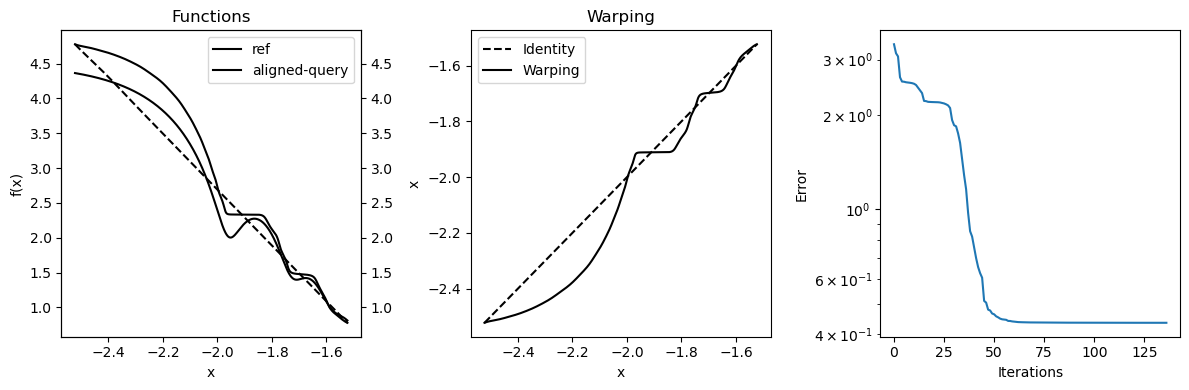

In [79]:
print(f'Amplitude: {amplitude}\nPhase: {phase}')
plot_warping_torch(q_grid, target_I, I_baseline_bad, output)

In [83]:
I_baseline = best_samples[-1]['I_scaled']
amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(I_baseline), 
                                        **optim_kwargs
                                        )

tensor(1.0000)
tensor(0.0005, dtype=torch.float64)


Amplitude: 0.021779718098199157
Phase: 0.009808296337723732


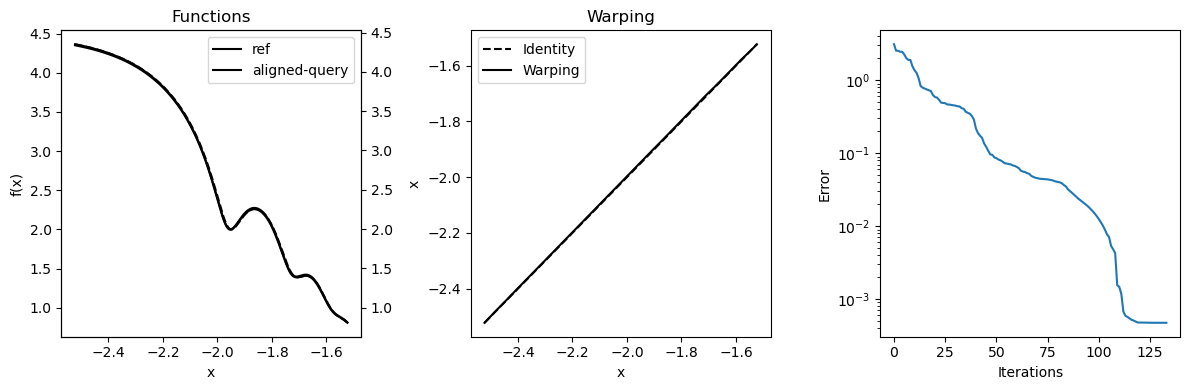

In [84]:
print(f'Amplitude: {amplitude}\nPhase: {phase}')
plot_warping_torch(q_grid, target_I, I_baseline, output)

In [27]:
amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(target_I), 
                                        **optim_kwargs
                                        )

In [31]:
entry

{'teos_vol_frac': 0.04594780006445944,
 'ammonia_vol_frac': 0.08236495736986399,
 'water_vol_frac': 0.12192985116969794,
 'scattering_I': array([1.72024529e+04, 1.70402061e+04, 1.68800764e+04, ...,
        1.76034822e+00, 1.74349084e+00, 1.72695129e+00]),
 'real_sampled_point': [0.045948720328794296,
  0.08234202924027659,
  0.12199286175902146],
 'diameter': 239.00137720377128,
 'pdi': 0.3465484135531559,
 'distance': 0.47100081238268954,
 'ap_distance_reporting': 0.47100081238268954,
 'I_scaled': array([4.77768761, 4.77357207, 4.76947164, ..., 0.78769582, 0.7835169 ,
        0.77937732])}

In [29]:
phase

0

In [30]:
output

(<funcshape.functions.Function at 0x77e9ee6473e0>,
 CurveReparametrizer(
   (layerlist): ModuleList(
     (0-14): 15 x PalaisMetric()
   )
 ),
 array([4.42491177, 3.12903866, 3.0579263 , 2.87582516, 2.20252094,
        2.20164401, 2.1944583 , 2.19144149, 2.18755205, 2.09429887,
        2.06930856, 2.00456651, 1.99223174, 1.98445596, 1.96161099,
        1.95549611, 1.95018698, 1.93389344, 1.92126783, 1.86712897,
        1.77781191, 1.71042752, 1.59783333, 1.55815452, 1.5431167 ,
        1.53276856, 1.49963179, 1.48027249, 1.46498127, 1.45594116,
        1.42667068, 1.39082878, 1.31552947, 1.30174567, 1.21945714,
        1.18758111, 1.00021733, 0.9704791 , 0.89324582, 0.86904674,
        0.8514203 , 0.82412865, 0.81748479, 0.80585667, 0.79536835,
        0.76684314, 0.71579003, 0.63971677, 0.58631061, 0.58286591,
        0.5792345 , 0.57603404, 0.56024245, 0.55667027, 0.5550891 ,
        0.54968734, 0.54549712, 0.53646306, 0.53193462, 0.51626703,
        0.50893738, 0.50788957, 0.5019395

In [21]:
baseline_best = best_samples[-1]['I_scaled']
baseline_bad = best_samples[-4]['I_scaled']
baseline_apdist_best = target_comparison.ap_distance(q_grid_scaled, baseline_best, target_I)
baseline_apdist_bad = target_comparison.ap_distance(q_grid_scaled, baseline_bad, target_I)

In [10]:
target_comparison.rmse_distance(baseline_best, target_I)

0.0025039412472410306

## Trajectory for random:

In [91]:
with open('SobolBaseline_replicate_0.pkl', 'rb') as f:
    random_0 = pickle.load(f)

In [103]:
best_samples_sobol = []
best_uuids_sobol = []
best_apdist_sobol = None
for uuid_val, entry in random_0.items():
    if best_apdist_sobol is None:
        best_apdist_sobol = entry['ap_distance_reporting']
        best_samples_sobol.append(entry)
        best_uuids_sobol.append(uuid_val)
    else:
        if entry['ap_distance_reporting'] < best_apdist_sobol:
            best_apdist_sobol = entry['ap_distance_reporting']
            best_samples_sobol.append(entry)
            best_uuids_sobol.append(uuid_val)

410ee21a-bc9b-43f3-a598-46c250d7646c
tensor(0.8709)
tensor(0.4348, dtype=torch.float64)


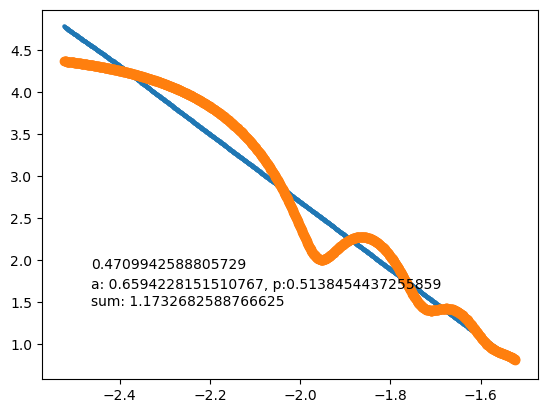

35db0e05-3fc4-42fa-8a78-b19781e16fba
tensor(0.8714)
tensor(0.4358, dtype=torch.float64)


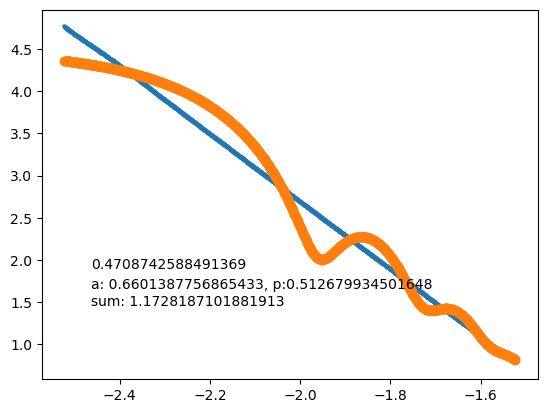

e5b61f1e-f0f3-4880-90ea-351ef760f1b4
tensor(0.9365)
tensor(0.4340, dtype=torch.float64)


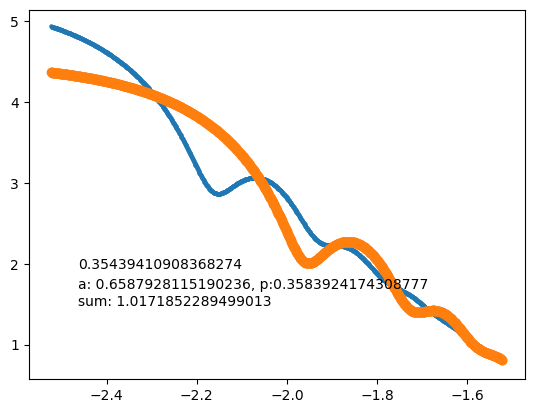

12bdca0d-a121-4d1f-ac9e-5660cc8755ab
tensor(0.9507)
tensor(0.1478, dtype=torch.float64)


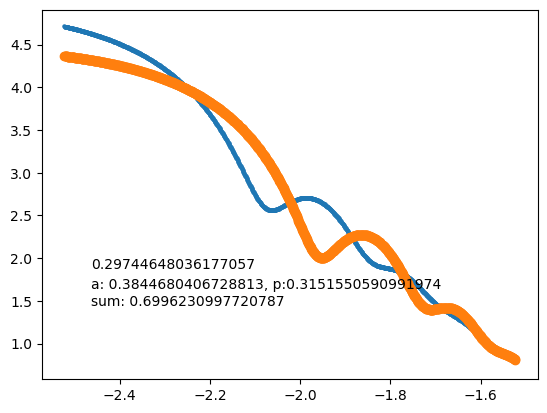

5897060d-83e9-472c-93d8-9c40a6e930ed
tensor(0.9956)
tensor(0.0742, dtype=torch.float64)


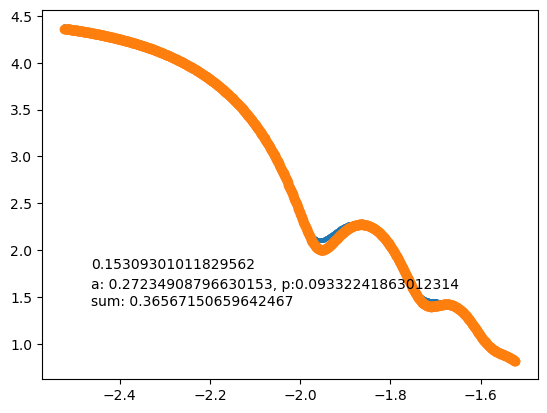

In [104]:
for uid, entry in zip(best_uuids_sobol, best_samples_sobol):
    print(uid)
    amplitude, phase, output = torch_apdist(torch.from_numpy(q_grid_scaled), # all the inputs should be torch.Tensor
                                        torch.from_numpy(target_I), 
                                        torch.from_numpy(entry['I_scaled']), 
                                        **optim_kwargs
                                        )
    fig, ax = plt.subplots()
    ax.scatter(q_grid, entry['I_scaled'], s = 5)
    ax.scatter(q_grid, target_I)
    ax.text(0.1, 0.3, entry['ap_distance_reporting'],  transform=ax.transAxes)
    ax.text(0.1, 0.2, f'a: {amplitude}, p:{phase}\nsum: {amplitude + phase}',  transform=ax.transAxes)
    plt.show()

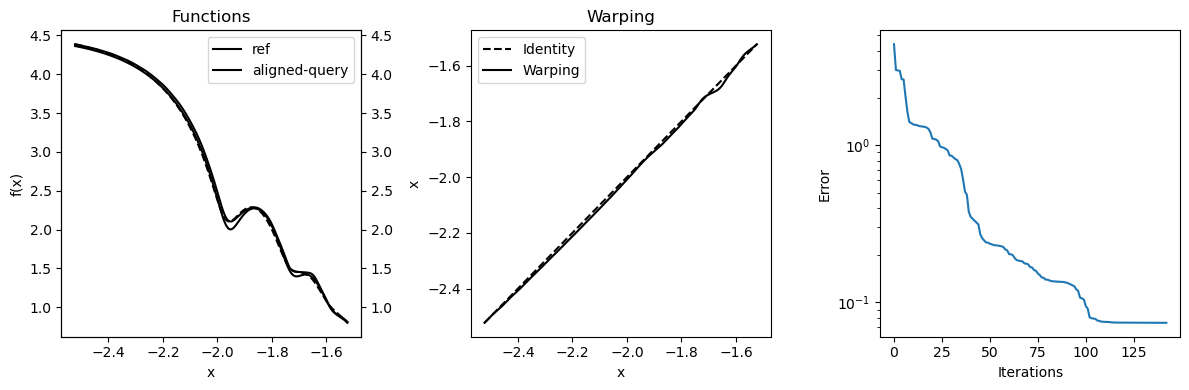

In [97]:
plot_warping_torch(q_grid, target_I, entry['I_scaled'], output)

In [40]:
min(I_sobolbest)

0.7999599513106405

In [41]:
max(I_sobolbest)

4.386881566203402

In [14]:
I_sobolbest = best_samples_sobol[-1]['I_scaled']

In [23]:
sobol_apdist = target_comparison.ap_distance(q_grid_scaled, I_sobolbest, target_I)

In [25]:
q_grid_scaled

array([0.00e+00, 1.00e-03, 2.00e-03, ..., 9.98e-01, 9.99e-01, 1.00e+00])

In [24]:
sobol_apdist

(0.2158140521555956, 0.14612400544748838)

In [17]:
target_comparison.rmse_distance(I_sobolbest, target_I)

0.007524719572170647

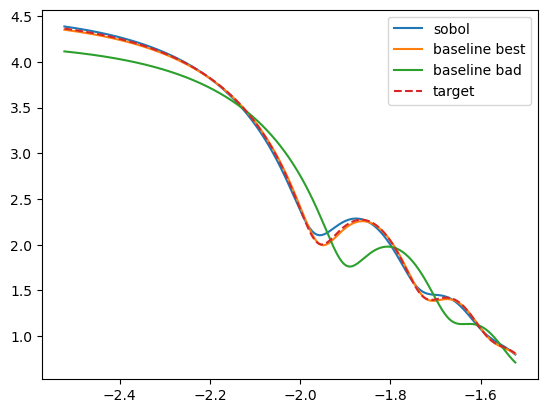

In [18]:
fig, ax = plt.subplots()

ax.plot(q_grid, I_sobolbest, label = 'sobol')
ax.plot(q_grid, baseline_best, label = 'baseline best')
ax.plot(q_grid, baseline_bad, label = 'baseline bad')

ax.plot(q_grid, target_I, ls = '--', label = 'target')
ax.legend()

In [32]:
print(f'Baseline best ap: {baseline_apdist_best}, \nbaseline bad ap: {baseline_apdist_bad} \nSobol best ap: {sobol_apdist}')

Baseline best ap: (0.027511264405298184, 0.014296027223231861), 
baseline bad ap: (0.18567726399739787, 0.1349587932314359) 
Sobol best ap: (0.2158140521555956, 0.14612400544748838)


In [27]:
optim_kwargs = {"optim":"DP", "grid_dim":10}

## Sobol best sample

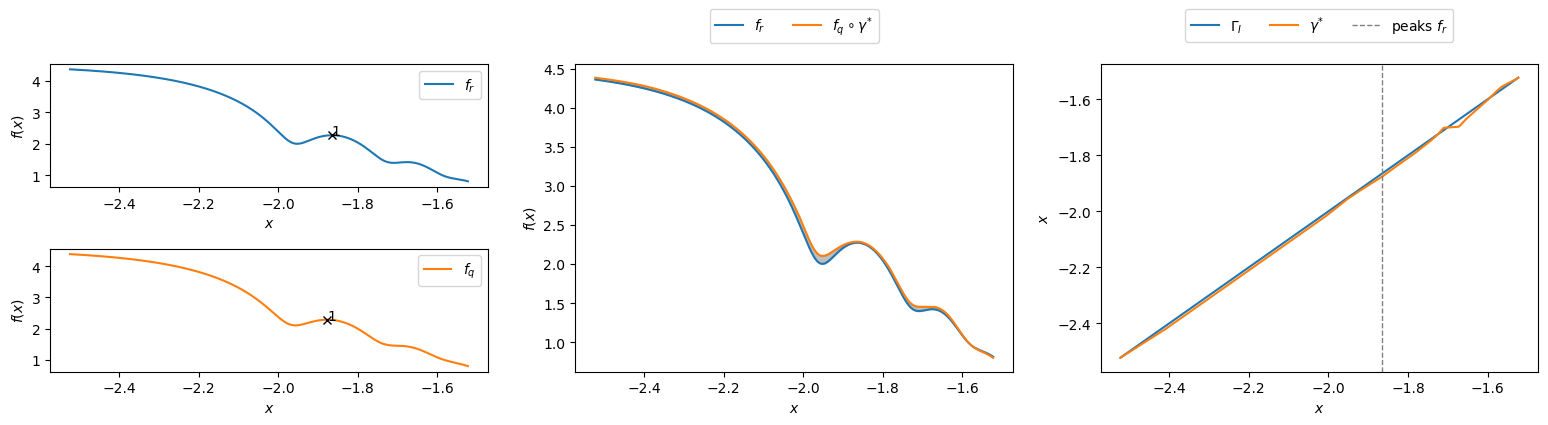

In [45]:
srsf = SRSF(q_grid_scaled)
q_ref = srsf.to_srsf(target_I)
q_query = srsf.to_srsf(I_sobolbest)
gamma = srsf.get_gamma(q_ref, q_query, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(I_sobolbest, gamma)
plot_warping(q_grid, target_I, I_sobolbest, f_query_gamma, gamma)
plt.show()

In [46]:
dist(q_grid_scaled, target_I, I_sobolbest, **optim_kwargs)

(0.2200580508943256, 0.14815613141501183)

## Baseline optimized 'bad' sample

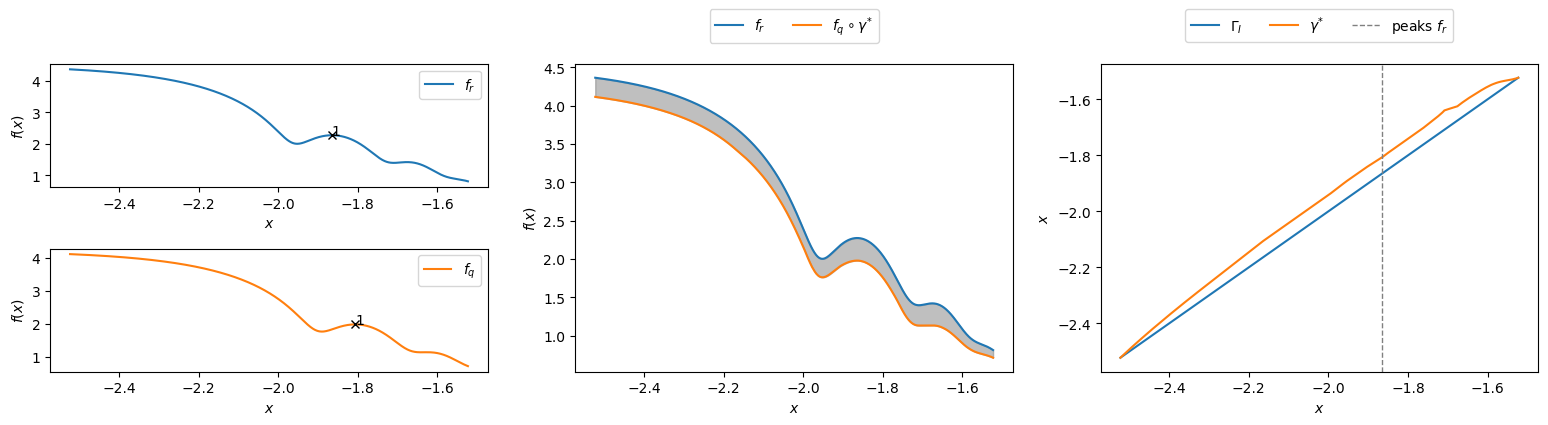

In [47]:
srsf = SRSF(q_grid_scaled)
q_ref = srsf.to_srsf(target_I)
q_query = srsf.to_srsf(baseline_bad)
gamma = srsf.get_gamma(q_ref, q_query, **optim_kwargs)
f_query_gamma = srsf.warp_f_gamma(baseline_bad, gamma)
plot_warping(q_grid, target_I, baseline_bad, f_query_gamma, gamma)
plt.show()

In [48]:
q_grid_scaled

array([0.00e+00, 1.00e-03, 2.00e-03, ..., 9.98e-01, 9.99e-01, 1.00e+00])

In [44]:
dist(q_grid_scaled, target_I, baseline_bad, **optim_kwargs)

(0.18604145767109964, 0.1350732271310796)

In [49]:
np.save('../apdistance_troubleshooting/q_grid_scaled.npy', q_grid_scaled)

In [50]:
np.save('../apdistance_troubleshooting/q_grid.npy', q_grid)

In [51]:
np.save('../apdistance_troubleshooting/I_sobol.npy', I_sobolbest)

In [52]:
np.save('../apdistance_troubleshooting/I_baseline.npy', baseline_bad)

In [53]:
np.save('../apdistance_troubleshooting/targetI.npy', target_I)